# Image Classification of Metal Surface Defects Using Deep Learning

## Introduction

In the manufacturing and energy industries, metal components are frequently exposed to various surface defects that can compromise their integrity and performance. These defects, such as scratches, dents, and corrosion, can lead to costly maintenance, operational inefficiencies, and even safety hazards. As the demand for high-quality products increases, there is a growing need for automated systems that can accurately classify these defects to ensure quality control.

This project aims to develop an image classification model to identify and classify metal surface defects using deep learning techniques. We will leverage pre-trained models within the pytorch framework to achieve this goal. 

The objectives of this project include:
- Analyzing a dataset of metal surface images to understand defect types and distributions.
- Implementing and training the aforementioned models on the dataset.
- Evaluating model performance and tuning the best-performing model to maximize classification accuracy.



## Project Outline
This outline presents the main sections of the project:

1. **Dataset Description**
2. **Data Exploration**
3. **Data Preparation**
4. **Model Training**
5. **Model Evaluation**
6. **Hyperparameter Tuning**
7. **Inference and Model Saving**
8. **Conclusion**

### 1.Dataset Description

The dataset consists of images of metal surface defects obtained from two separate sources: the **gc10det** dataset and the **NEU Surface Defect Database**. It includes various classes of defects such as:

- **Crease**: Folded or bent areas on the metal surface.
- **Crescent Gap**: Gaps or voids in a crescent shape.
- **Inclusion**: Foreign particles embedded within the metal surface.
- **Oil Spot**: Residues of oil affecting the metal surface.
- **Punching Hole**: Holes created during the punching process.
- **Rolled in Scale**: Scale rolled into the surface, creating rough textures.
- **Rolled Pit**: Pits or depressions caused by rolling defects.
- **Scratches**: Linear abrasions on the metal surface.
- **Silk Spot**: Silk-like spots resulting from processing issues.
- **Waist Folding**: Folds appearing during bending or shaping.
- **Water Spot**: Marks left by water during cleaning or processing.
- **Welding Line**: Defects along welding seams.




## 2.Data Exploration

In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

In [2]:
#explore the directories and images in the data
data_path = '/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects'
data_path = Path(data_path)
for dirpath,dirnames,filenames in os.walk(data_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 13 directories and 0 images in /kaggle/input/metal-surfaces-defects/Metal-surfaces-defects
There are 0 directories and 3014 images in /kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/lable
There are 0 directories and 516 images in /kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/inclusion
There are 0 directories and 31 images in /kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/rolled_pit
There are 0 directories and 204 images in /kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/oil_spot
There are 0 directories and 226 images in /kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/crescent_gap
There are 0 directories and 53 images in /kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/crease
There are 0 directories and 150 images in /kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/waist_folding
There are 0 directories and 300 images in /kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/rolled_in_scal

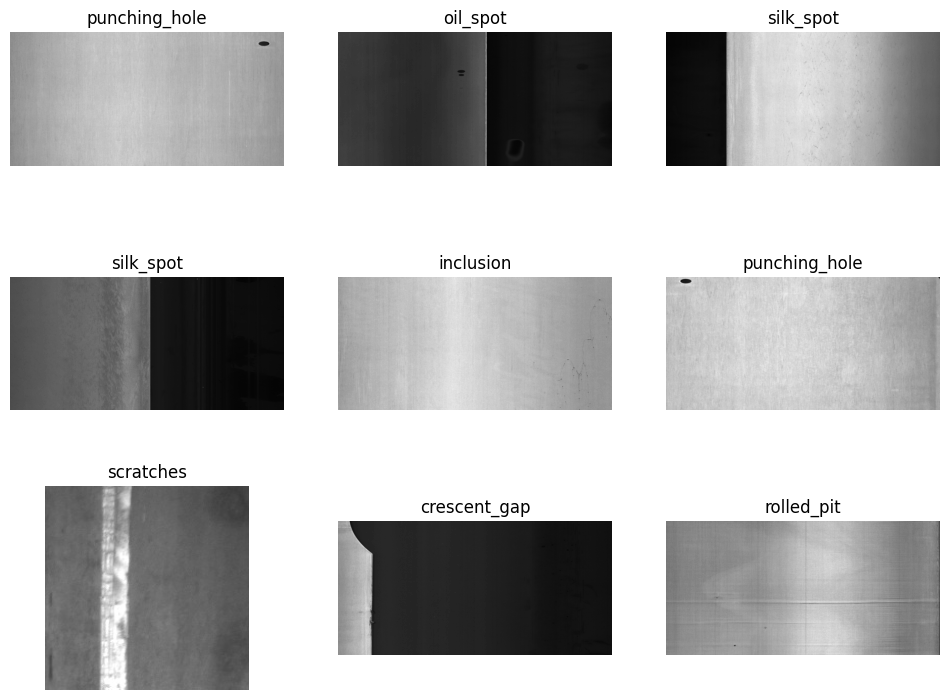

In [3]:
# define number of images to plot
num_images = 9
image_path_list = list(data_path.glob('*/*.jpg'))
random_images = random.sample(image_path_list,k=num_images)
num_row = num_images // 3  
num_col = 3
plt.figure(figsize=(12,9))
for i,img in enumerate(random_images):
    with Image.open(img) as f:
        plt.subplot(num_row,num_col,i+1)
        plt.imshow(f,cmap = 'gray')
        plt.title(f'{img.parent.stem}')
        plt.axis(False)

## 3.Data Preparation
In this section, we will prepare the data for training by following these steps:
* Removing the lable folder and crease, rollid_pit classes since they don't have enough images for training
* Split the data into training set(80%), validation set (20%) and testing set(20%)
* Transform the data by applying Resizing ,normalization and convert into tensors
* Finally split the sets into batches of 32.

In [4]:
#copy the data since Input is read only
data_path = '/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects'
working_path = '/kaggle/working/Dataset'
if not os.path.exists(working_path):
    shutil.copytree(data_path,working_path)
    print(f"Copied dataset to: {working_path}")
else:
    print(f"Backup folder already exists: {working_path}")

Copied dataset to: /kaggle/working/Dataset


In [5]:
# Remove the folders 
folders_to_remove = ['lable', 'rolled_pit', 'crease']
for folder in folders_to_remove:
    path = os.path.join(working_path,folder)
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f'{folder} folder was removed')

lable folder was removed
rolled_pit folder was removed
crease folder was removed


### Data splitting

In [6]:
# put all the data into a list to split it
remaining_folders = [f for f in os.listdir(working_path) if os.path.isdir(os.path.join(working_path, f))]
file_paths = []
labels = []
for label in remaining_folders:
    label_folder_path = os.path.join(working_path, label)
    for filename in os.listdir(label_folder_path):
        file_paths.append(os.path.join(label_folder_path,filename))
        labels.append(label)

In [7]:
# First split: train_val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(file_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Second split: train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val) 

In [8]:
# create the new folders for splitted data
output_dir = '/kaggle/working/split_dataset'
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

In [9]:
# move the file to the splitted folders
def move_files(file_list,labels,target_folder):
    for file_path,label in zip(file_list,labels):
        target_path = os.path.join(output_dir,target_folder,label)
        os.makedirs(target_path, exist_ok=True)
        shutil.copy(file_path, target_path)
move_files(X_train,y_train,'train')
move_files(X_val,y_val,'val')
move_files(X_test,y_test,'test')

In [10]:
data_path = Path('/kaggle/working/split_dataset')
train_dir =  data_path/ 'train'
val_dir = data_path / 'val'
test_dir = data_path / 'test'

### Data transformation

In [11]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=train_dir,transform=transform)
val_data = datasets.ImageFolder(root=val_dir,transform=transform)
test_data = datasets.ImageFolder(root=test_dir,transform=transform)

# split the datasets into batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## 4.Model Training
Now we're ready for the training phase. I have chosen three architectures to train: ResNet18, EfficientNetB0, EfficientNetB2, VGG16, and VGG19. To accomplish this, we will follow these steps:

1. Load the models.
2. Freeze the backbone parameters and create the classifier, using a dropout rate of 0.2 and a linear layer.
3. Set up the loss function and the optimizer.
4. Establish the training loop.
5. Train all models for 20 epochs.


### Load the models

In [12]:
res_weights  = models.ResNet18_Weights.DEFAULT
eff0_weights  = models.EfficientNet_B0_Weights.DEFAULT
eff2_weights  = models.EfficientNet_B2_Weights.DEFAULT
vgg16_weights  = models.VGG16_Weights.DEFAULT
vgg19_weights  = models.VGG19_Weights.DEFAULT
res_model = models.resnet18(weights=res_weights)
eff0_model = models.efficientnet_b0(weights=eff0_weights)
eff2_model = models.efficientnet_b2(weights=eff2_weights)
vgg16_model = models.vgg16(weights=vgg16_weights)
vgg19_model = models.vgg19(weights=vgg19_weights)
model_list = [res_model, eff0_model, eff2_model,vgg16_model,vgg19_model]
model_list = list(model_list)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 177MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 131MB/s] 
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 216MB/s] 
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 213MB/s] 


### Cutomize the models

In [11]:
#set the device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The used device: {device}')

The used device: cuda


In [14]:
# Freeze the backbone parameters
for model in model_list:
    for param in model.parameters():
        param.requires_grad = False
res_features = res_model.fc.in_features
# Create the classifier
res_model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(res_features,10)
)
eff0_model.classifier  = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(1280,10)
)
eff2_model.classifier  = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(1408,10)
)
vgg16_model.classifier  = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(25088,10)
)
vgg19_model.classifier  = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(25088,10)
)
res_model = res_model.to(device)
eff0_model = eff0_model.to(device)
eff2_model = eff2_model.to(device)
vgg16_model = vgg16_model.to(device)
vgg19_model = vgg19_model.to(device)

## Training loop

In [12]:

def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=20):
    """
    Trains and evaluates a model over multiple epochs.

    Parameters:
        model (torch.nn.Module): The model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        loss_fn (torch.nn.Module): Loss function to calculate the training and validation loss.
        device (torch.device): Device to run the model on (e.g., 'cpu' or 'cuda').
        num_epochs (int): Number of epochs to train the model. Default is 20.

    Returns:
        tuple: A tuple containing four lists:
            - train_losses (list of float): Average training loss for each epoch.
            - valid_losses (list of float): Average validation loss for each epoch.
            - train_accuracies (list of float): Training accuracy (%) for each epoch.
            - valid_accuracies (list of float): Validation accuracy (%) for each epoch.
    """
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss = 0
        valid_loss = 0
        correct_train = 0
        total_train = 0
        correct_valid = 0
        total_valid = 0

        # Training loop
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate total training loss
            train_loss += loss.item() * images.size(0)
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Average training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                # Accumulate total validation loss
                valid_loss += loss.item() * images.size(0)
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        # Average validation loss and accuracy
        valid_loss /= len(val_loader.dataset)
        valid_accuracy = 100 * correct_valid / total_valid
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        # Print training and validation statistics
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%')

    return train_losses, valid_losses, train_accuracies, valid_accuracies



In [16]:
#set the loss
loss_fn = nn.CrossEntropyLoss()
# train the models
for model in model_list:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    print(f'\nTraining {model.__class__.__name__}')
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        model, train_loader, val_loader, optimizer, loss_fn, device
    )


Training ResNet
Epoch [1/20], Train Loss: 1.9282, Train Accuracy: 36.46%, Valid Loss: 1.4719, Valid Accuracy: 58.31%
Epoch [2/20], Train Loss: 1.2696, Train Accuracy: 58.96%, Valid Loss: 1.0598, Valid Accuracy: 68.53%
Epoch [3/20], Train Loss: 1.0342, Train Accuracy: 68.12%, Valid Loss: 0.9186, Valid Accuracy: 69.65%
Epoch [4/20], Train Loss: 0.9280, Train Accuracy: 70.68%, Valid Loss: 0.8079, Valid Accuracy: 75.08%
Epoch [5/20], Train Loss: 0.8336, Train Accuracy: 74.25%, Valid Loss: 0.7511, Valid Accuracy: 76.36%
Epoch [6/20], Train Loss: 0.7882, Train Accuracy: 75.48%, Valid Loss: 0.7091, Valid Accuracy: 78.12%
Epoch [7/20], Train Loss: 0.7444, Train Accuracy: 76.44%, Valid Loss: 0.6749, Valid Accuracy: 79.87%
Epoch [8/20], Train Loss: 0.6956, Train Accuracy: 78.62%, Valid Loss: 0.6422, Valid Accuracy: 79.87%
Epoch [9/20], Train Loss: 0.6785, Train Accuracy: 77.61%, Valid Loss: 0.6333, Valid Accuracy: 79.87%
Epoch [10/20], Train Loss: 0.6476, Train Accuracy: 79.53%, Valid Loss: 0.6

 ## 5.Model Evaluation
 To find the best model, we will evaluate the model based on the accuracy and loss

In [13]:
def evaluate_model(model,data_loader,device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            loss = loss_fn(pred,y)
            total_loss += loss.item()*X.size(0)
            _, predicted = torch.max(pred, 1)
            correct += (predicted==y).sum().item()
            total += y.size(0)
        avg_loss = total_loss / len(data_loader.dataset)
        accuracy = 100 * correct / total
    return {"loss": avg_loss, "accuracy": accuracy}

In [14]:
# Define function to calculate model size in MB
def get_model_size(model):
    param_size = sum(param.numel() * param.element_size() for param in model.parameters())
    buffer_size = sum(buffer.numel() * buffer.element_size() for buffer in model.buffers())
    total_size = param_size + buffer_size
    return total_size / (1024 ** 2)  # Convert bytes to MB

In [21]:
# Model list including VGG16 and VGG19
model_list = [
    ("ResNet18", res_model),
    ("EfficientNet_B0", eff0_model),
    ("EfficientNet_B2", eff2_model),
    ("VGG16", vgg16_model),
    ("VGG19", vgg19_model)
]
res = []
for model_name, model in model_list:
    model.to(device)
    
    # Evaluate the model
    metrics = evaluate_model(model, val_loader, device)
    
    # Add model name and size to metrics
    metrics['model'] = model_name
    metrics['size_mb'] = get_model_size(model)  # Add model size in MB
    
    res.append(metrics)

# Convert results to a DataFrame
res_df = pd.DataFrame(res)

In [22]:
res_df.set_index('model')

,loss,accuracy,size_mb
model,,,
ResNet18,0.528078,81.789137,42.691353
EfficientNet_B0,0.652450,79.712460,15.497101
EfficientNet_B2,0.754617,78.434505,29.688988
VGG16,0.357280,88.977636,57.089149
VGG19,0.370735,87.859425,77.344032


It's clear from  the evaluation of the models that VGG16 is the best model among the trained models with an accuracy of `88.98%` and a loss of `0.36`

## 6.Hyperparameter Tuning


In this section, we followed these steps:

- Applied data augmentation to the training dataset to improve generalization.
- Used the original VGG16 model as the classifier.
- Experimented with different optimizers (Adam, SGD, RMSprop) and learning rates (0.0001, 0.001, 0.01).
- Evaluated model performance based on:
    - Training and validation losses
    - Training and validation accuracies
- Plotted results to compare the performance of different hyperparameter configurations.
- Train the vgg model with the best hyperparameters for 30 opochs


In [15]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=train_dir,transform=train_transform)
val_data = datasets.ImageFolder(root=val_dir,transform=test_transform)
test_data = datasets.ImageFolder(root=test_dir,transform=test_transform)

# split the datasets into batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [19]:
def model_setup():
    vgg16_weights  = models.VGG16_Weights.DEFAULT
    vgg16_model = models.vgg16(weights=vgg16_weights)
    vgg16_model.classifier[6] = nn.Linear(in_features=4096, out_features=10)
    vgg16_model = vgg16_model.to(device)
    return vgg16_model
    

In [17]:
def result_dict(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=20):
    res = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }
    
    # Call train_model and unpack the results directly into the dictionary
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs
    )
    
    # Store results in the dictionary
    res['train_loss'] = train_losses
    res['val_loss'] = valid_losses
    res['train_acc'] = train_accuracies
    res['val_acc'] = valid_accuracies
    
    return res

In [21]:
# Define a list of learning rates and optimizers
learning_rates = [0.01,0.001, 0.0001]
optimizers = ['SGD', 'Adam', 'RMSprop']
epochs = 10

In [23]:
results = []
#set the device 
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
# Iterate through each learning rate and optimizer
for lr in learning_rates:
    for opt_name in optimizers:
        loss_fn = nn.CrossEntropyLoss()
        model = model_setup()
        # Setup the optimizer based on the optimizer name
        if opt_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif opt_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif opt_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        print(f"Training model with {opt_name} optimizer and learning rate {lr} for {10} epochs...")
        res = result_dict(model, train_loader, val_loader, optimizer, loss_fn, device, 10)
        res['title'] = f'{opt_name}_{lr}'
        results.append(res)
        

Training model with SGD optimizer and learning rate 0.01 for 10 epochs...
model 
Training model with Adam optimizer and learning rate 0.01 for 10 epochs...
model 
Training model with RMSprop optimizer and learning rate 0.01 for 10 epochs...
model 
Training model with SGD optimizer and learning rate 0.001 for 10 epochs...
model 
Training model with Adam optimizer and learning rate 0.001 for 10 epochs...
model 
Training model with RMSprop optimizer and learning rate 0.001 for 10 epochs...
model 
Training model with SGD optimizer and learning rate 0.0001 for 10 epochs...
model 
Training model with Adam optimizer and learning rate 0.0001 for 10 epochs...
model 
Training model with RMSprop optimizer and learning rate 0.0001 for 10 epochs...
model 


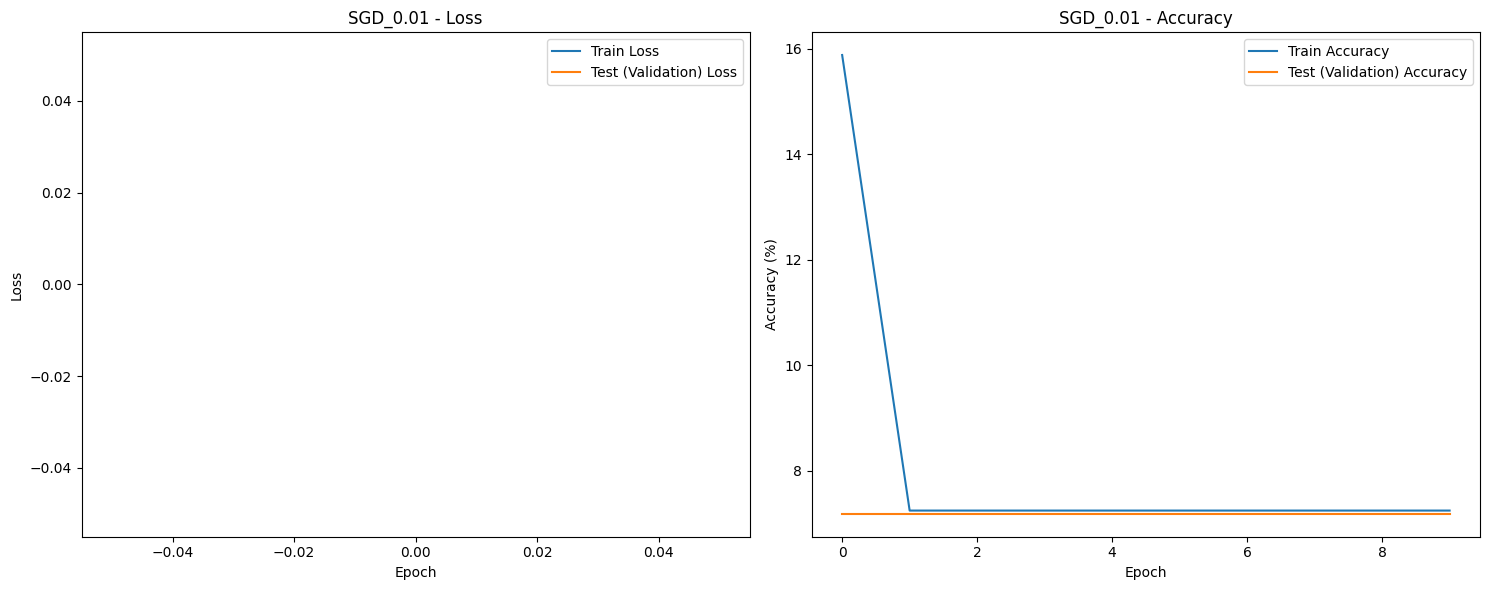

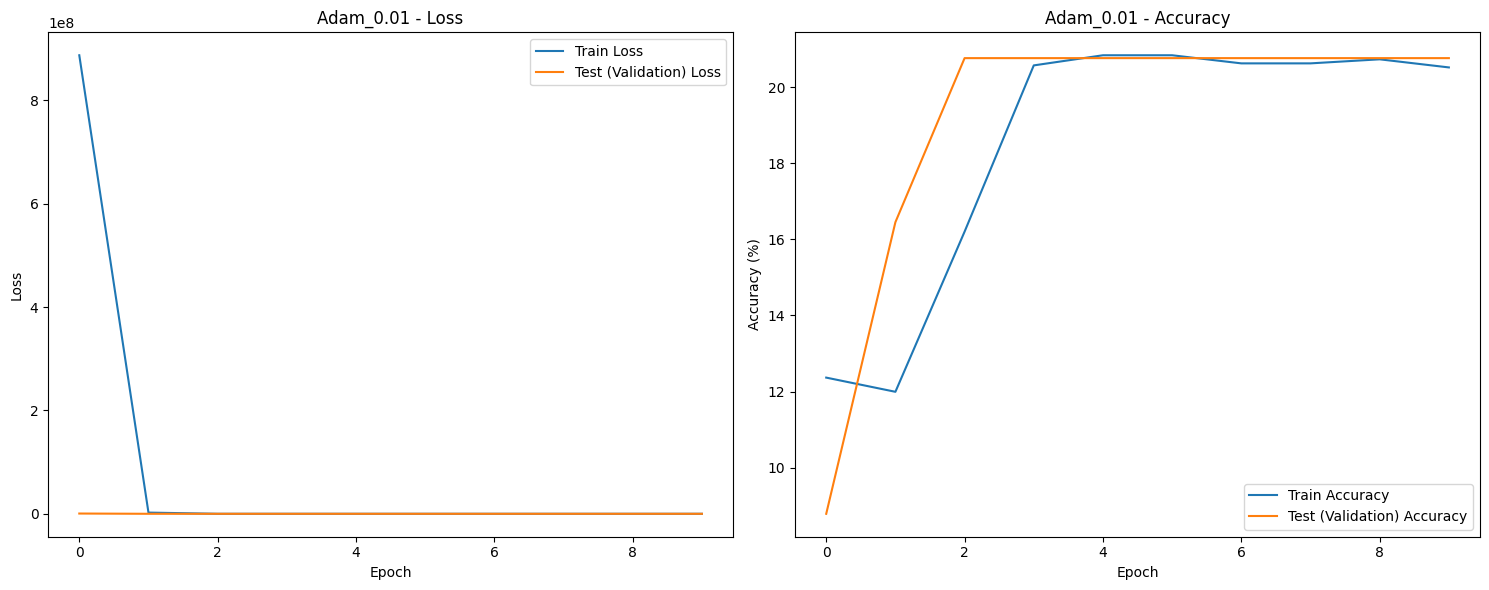

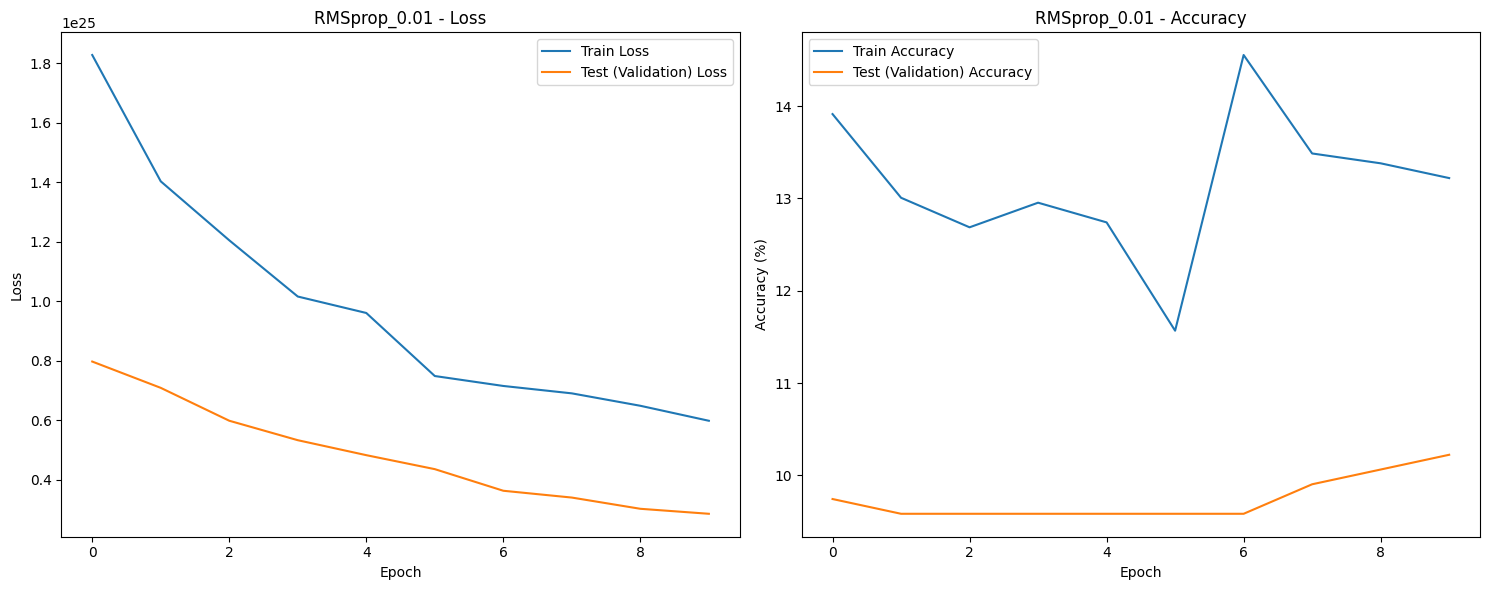

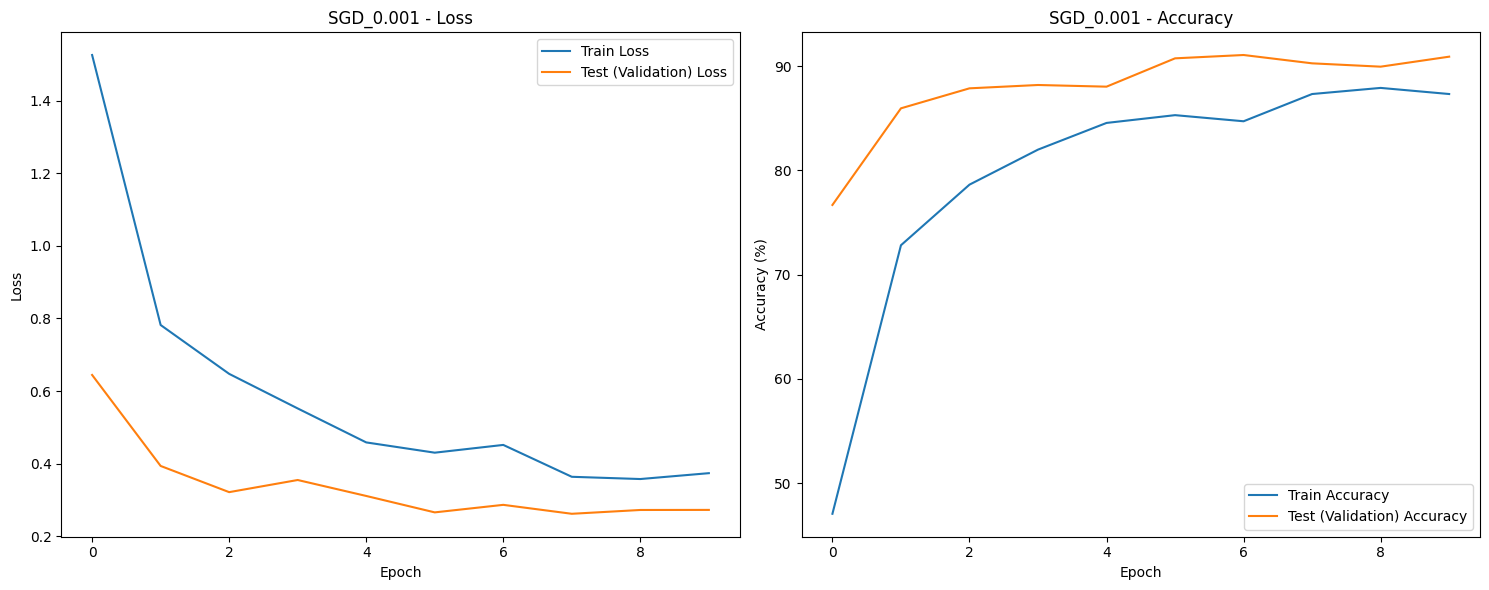

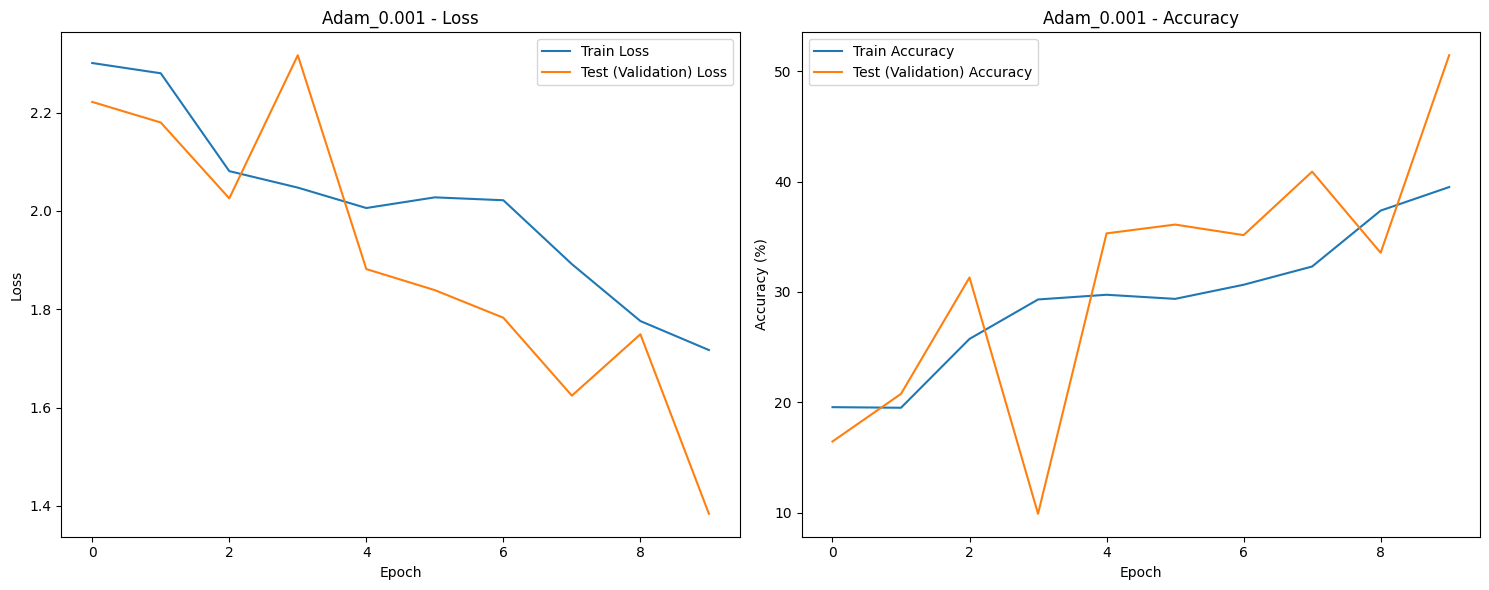

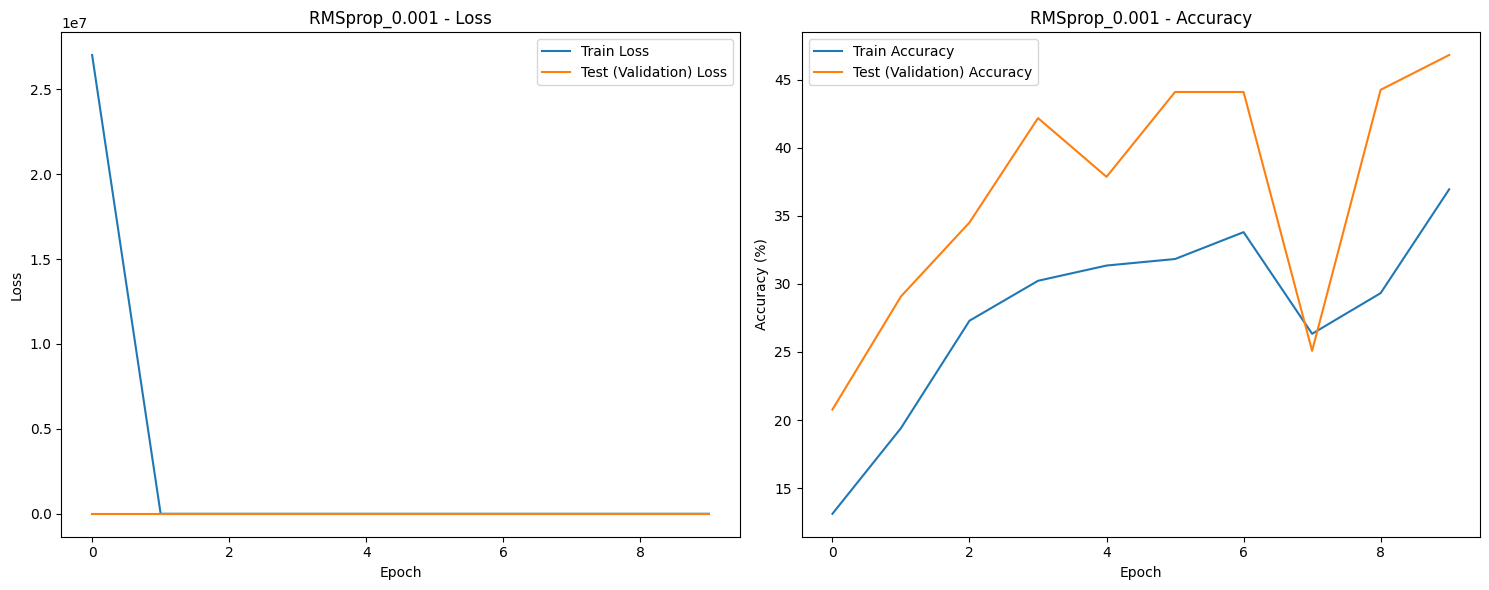

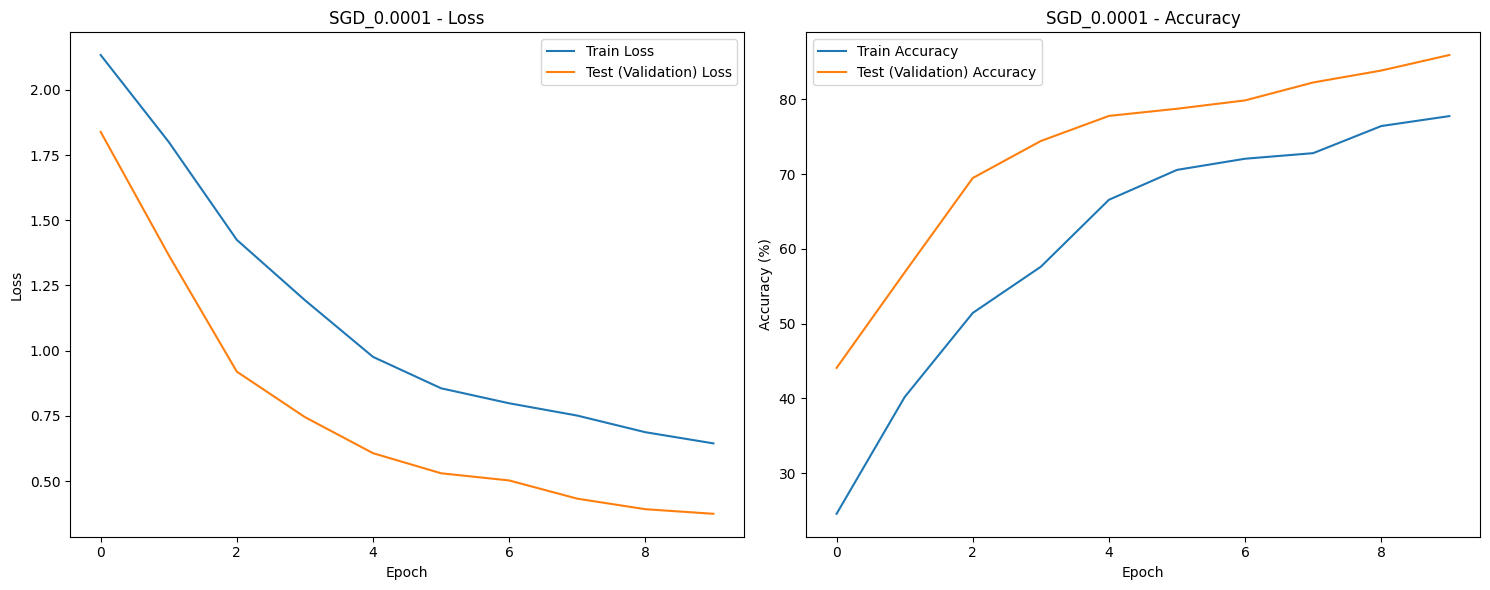

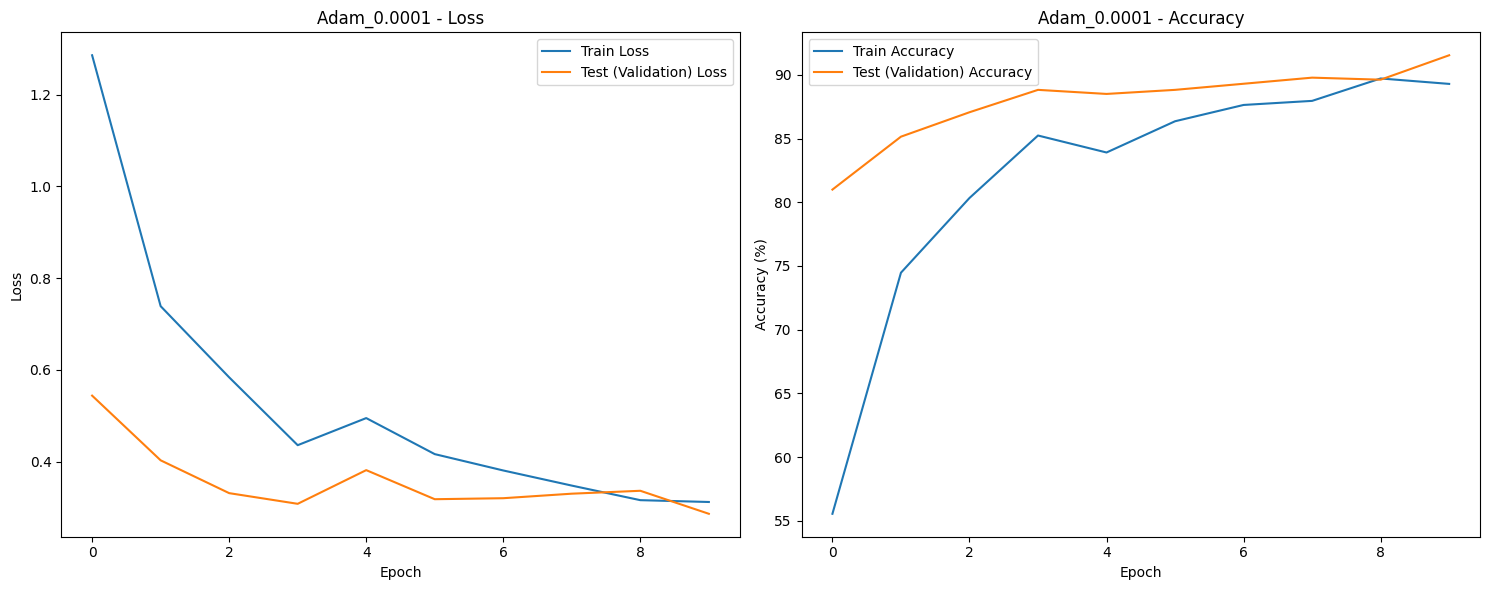

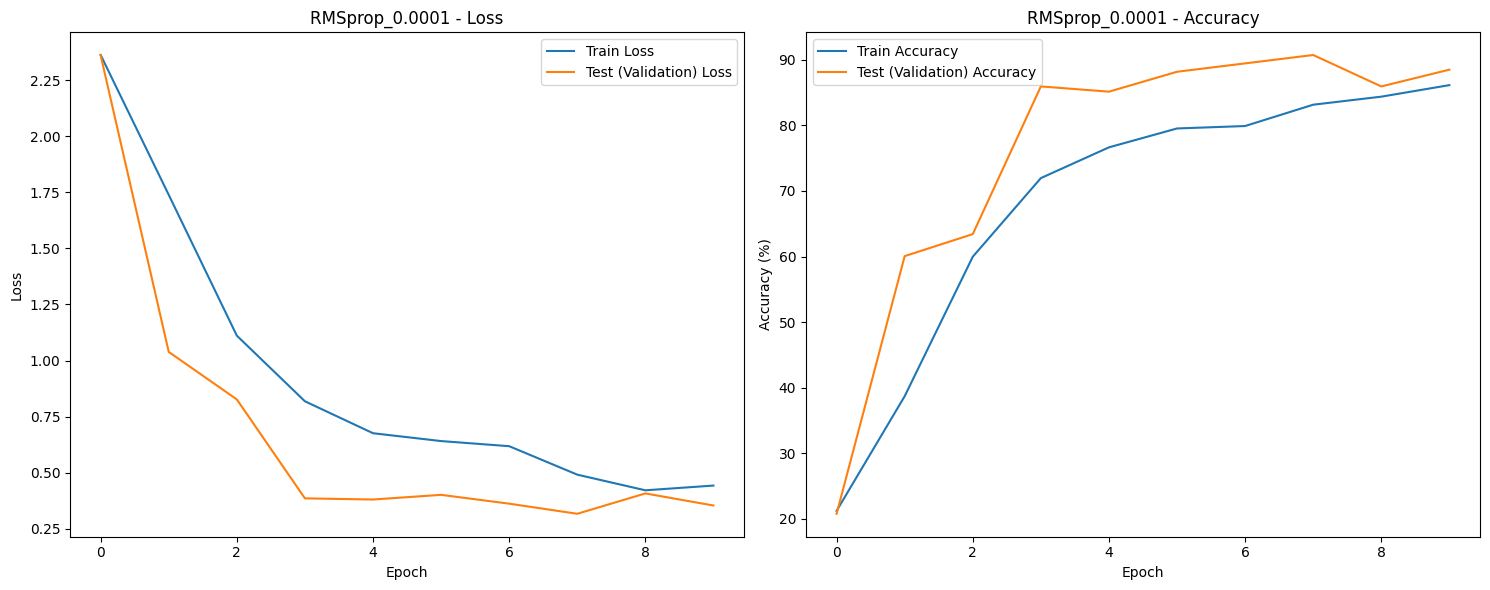

In [27]:
import matplotlib.pyplot as plt

# Assuming `results` contains the list of dictionaries from each experiment
# Each dictionary contains:
# - 'train_loss' and 'test_loss' (or 'val_loss') for training and validation losses
# - 'train_acc' and 'test_acc' (or 'val_acc') for training and validation accuracies
# - 'title' for the experiment name

for res_metrics in results:
    # Create a new figure for each experiment
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot for Train and Test (Validation) Loss
    axes[0].plot(res_metrics['train_loss'], label='Train Loss')
    axes[0].plot(res_metrics['val_loss'], label='Test (Validation) Loss')
    axes[0].set_title(f'{res_metrics["title"]} - Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='best')

    # Plot for Train and Test (Validation) Accuracy
    axes[1].plot(res_metrics['train_acc'], label='Train Accuracy')
    axes[1].plot(res_metrics['val_acc'], label='Test (Validation) Accuracy')
    axes[1].set_title(f'{res_metrics["title"]} - Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend(loc='best')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


After evaluating multiple experiments, I have chosen the experiment with the **Adam optimizer** and a learning rate of **0.0001** as the best model based on **validation accuracy**.

## The final training
we will train vgg16 model using Adam optimizer and a learning rate of 0.0001 for 30 opochs

In [21]:
final_model = model_setup()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0001)
res = result_dict(final_model, train_loader, val_loader, optimizer, loss_fn, device, 30)

Epoch [1/30], Train Loss: 1.1836, Train Accuracy: 59.75%, Valid Loss: 0.4606, Valid Accuracy: 87.54%
Epoch [2/30], Train Loss: 0.5997, Train Accuracy: 80.81%, Valid Loss: 0.3942, Valid Accuracy: 88.50%
Epoch [3/30], Train Loss: 0.5543, Train Accuracy: 82.36%, Valid Loss: 0.5427, Valid Accuracy: 82.91%
Epoch [4/30], Train Loss: 0.4395, Train Accuracy: 84.97%, Valid Loss: 0.3060, Valid Accuracy: 89.78%
Epoch [5/30], Train Loss: 0.4074, Train Accuracy: 86.51%, Valid Loss: 0.3175, Valid Accuracy: 89.14%
Epoch [6/30], Train Loss: 0.3815, Train Accuracy: 87.58%, Valid Loss: 0.3540, Valid Accuracy: 88.98%
Epoch [7/30], Train Loss: 0.3178, Train Accuracy: 89.23%, Valid Loss: 0.3410, Valid Accuracy: 89.62%
Epoch [8/30], Train Loss: 0.3602, Train Accuracy: 88.01%, Valid Loss: 0.3070, Valid Accuracy: 90.42%
Epoch [9/30], Train Loss: 0.3705, Train Accuracy: 87.53%, Valid Loss: 0.3139, Valid Accuracy: 89.62%
Epoch [10/30], Train Loss: 0.2487, Train Accuracy: 91.58%, Valid Loss: 0.4094, Valid Accura

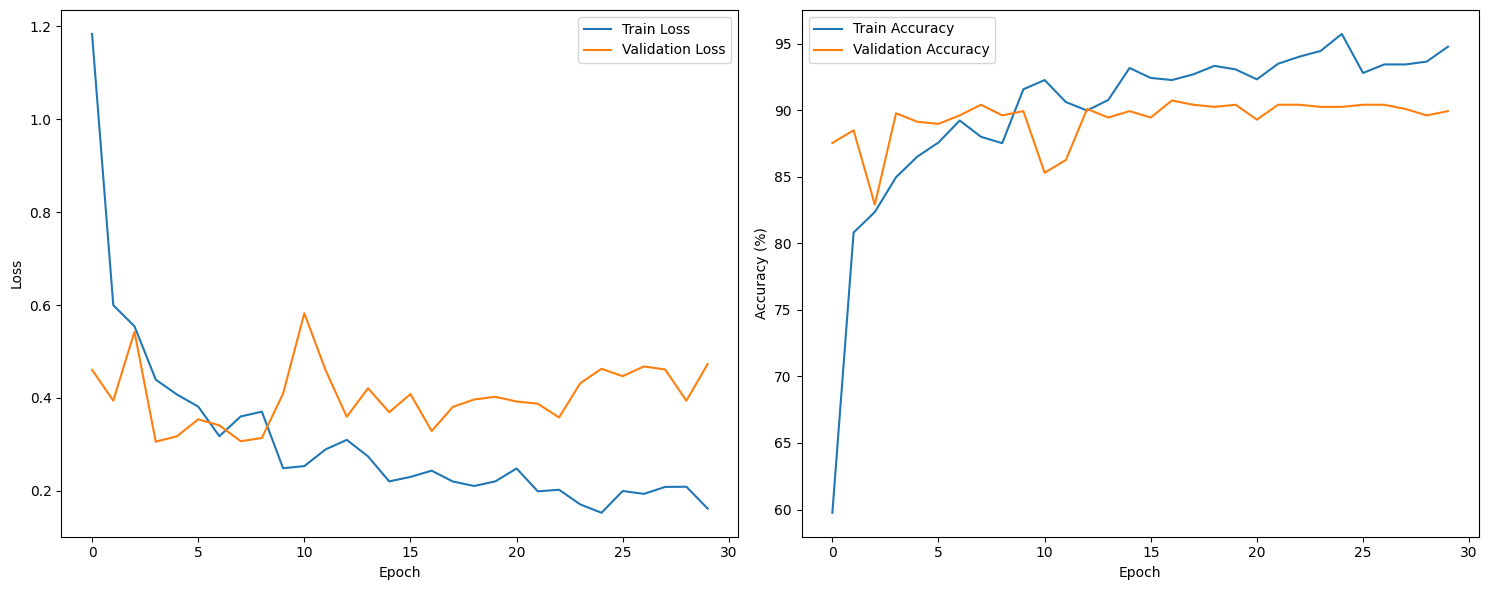

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Train and Test (Validation) Loss
axes[0].plot(res['train_loss'], label='Train Loss')
axes[0].plot(res['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

# Plot for Train and Test (Validation) Accuracy
axes[1].plot(res['train_acc'], label='Train Accuracy')
axes[1].plot(res['val_acc'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='best')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [27]:
final_model_res = evaluate_model(final_model,test_loader,device)

In [31]:
print(f"Test loss: {final_model_res['loss']:.2f} Test accuracy: {final_model_res['accuracy']:.2f}%")


Test loss: 0.35 Test accuracy: 90.42%


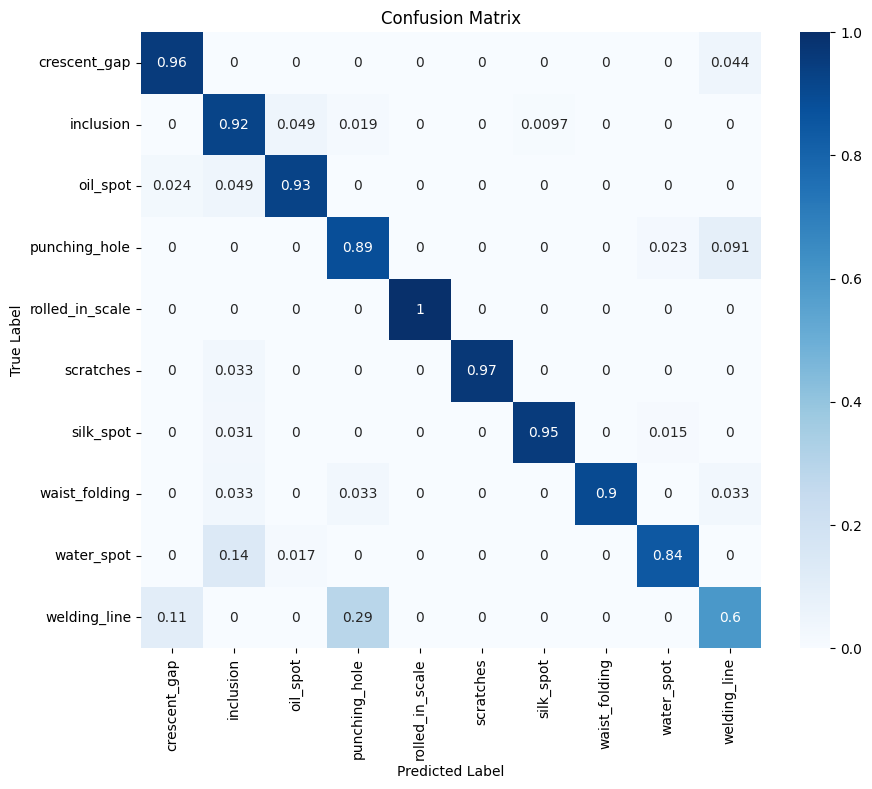

In [36]:

import torchmetrics
from torchmetrics.classification import ConfusionMatrix
import seaborn as sns

class_names = train_data.classes
# Number of classes
num_classes = len(class_names)  # Replace with the actual number of classes

# Initialize the confusion matrix metric from torchmetrics
confmat = ConfusionMatrix(task='multiclass',num_classes=num_classes).to(device)

# Set model to evaluation mode
final_model.eval()

# Calculate predictions and update confusion matrix
with torch.no_grad():
    for images, labels in test_loader:  # Replace test_loader with your DataLoader
        images, labels = images.to(device), labels.to(device)
        
        # Make predictions
        outputs = final_model(images)
        _, preds = torch.max(outputs, 1)
        
        # Update the confusion matrix with the predictions
        confmat.update(preds, labels)

# Retrieve the confusion matrix as a tensor
conf_matrix = confmat.compute()
conf_matrix_normalized = conf_matrix / conf_matrix.sum(axis=1, keepdim=True)
# Convert the confusion matrix to a numpy array for plotting
conf_matrix_normalized = conf_matrix_normalized.cpu().numpy()

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


As we can see the final model get a testing accuracy of `90.42%` and a testing loss of `0.35`.Now to will predict an image and plot it.

## 7.Inference and Model Saving

In [58]:
from PIL import Image
from PIL import Image
import torch
import matplotlib.pyplot as plt

def predict_plot_image(model, image_path, transform, device, class_names):
    # Load and transform the image
    img = Image.open(image_path)
    transformed_img = transform(img).unsqueeze(0).to(device)
    
    # Set model to evaluation mode
    model.eval()
    with torch.inference_mode():
        # Perform prediction
        logits = model(transformed_img)
        prob = torch.softmax(logits, dim=1)  # Get probabilities
        pred = torch.argmax(prob, dim=1).item()  # Get the predicted class index as an integer
    
    # Plot the image and display prediction
    plt.imshow(img, cmap='gray')  # Display grayscale image
    plt.title(f'Predicted label: {class_names[pred]} | Probability: {prob[0, pred].item():.2f}')
    plt.axis('off')
    plt.show()



In [59]:
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ensure single-channel output
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Single value for grayscale
])

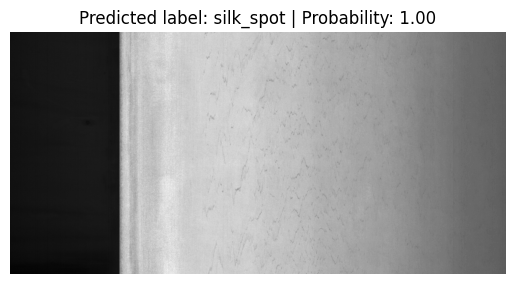

In [66]:
predict_plot_image(final_model,'/kaggle/input/metal-surfaces-defects/Metal-surfaces-defects/silk_spot/silk_spot (100).jpg',test_transform,device,class_names)

Finally we will save model to use for deployement.

In [63]:
import torch

# Save the trained model
torch.save(final_model.state_dict(), 'final_model.pth')
print("Trained model saved as final_model.pth")


Trained model saved as final_model.pth


## 8.Conclusion
Different pretrained models, including ResNet and EfficientNet, were tested for defect detection, with VGG16 performing the best in terms of accuracy and loss. Hyperparameter tuning was then applied to optimize VGG16, improving its performance further. This process emphasizes the importance of model selection and tuning for achieving optimal results.